In [3]:
# Define expected return and volatility based on risk level
risk_params = {
    1: {"expected_return": 0.038 / 12, "volatility": 0.049 / 12},
    2: {"expected_return": 0.056 / 12, "volatility": 0.07 / 12},
    3: {"expected_return": 0.066 / 12, "volatility": 0.097 / 12},
    4: {"expected_return": 0.072 / 12, "volatility": 0.177 / 12},
    5: {"expected_return": 0.093 / 12, "volatility": 0.204 / 12},
}

In [4]:
import numpy as np
import time

def monte_carlo_simulation(target_amount, current_lumpsum, months, risk_level, num_simulations=10000):

    if risk_level not in risk_params:
        raise ValueError("Invalid risk level. Choose between 1 and 5.")

    expected_return = risk_params[risk_level]["expected_return"]
    volatility = risk_params[risk_level]["volatility"]

    np.random.seed(0)  # For reproducibility

    # Pre-generate all random returns
    monthly_returns = np.random.normal(expected_return, volatility, (num_simulations, months))

    monthly_contributions = np.zeros(num_simulations)

    for i in range(num_simulations):
        monthly_contribution = 0
        current_value = current_lumpsum
        returns = monthly_returns[i]

        # Compute initial accumulated value with zero monthly contribution
        for month in range(months):
            current_value = current_value * (1 + returns[month]) + monthly_contribution

        # Increase monthly contribution until target is reached
        while current_value < target_amount:
            monthly_contribution += 1
            current_value = current_lumpsum

            for month in range(months):
                current_value = current_value * (1 + returns[month]) + monthly_contribution

        monthly_contributions[i] = monthly_contribution

    return np.percentile(monthly_contributions, [5, 50, 95])

def suggest_monthly_contributions(target_amount, current_lumpsum, months, risk_level):
    start_time = time.time()
    conf_interval = monte_carlo_simulation(target_amount, current_lumpsum, months, risk_level)
    end_time = time.time()
    print(f"Monte Carlo simulation took {end_time - start_time:.2f} seconds to run.")

    return {
        "mid_point": conf_interval[1],
        "range": (conf_interval[0], conf_interval[2])
    }

# Inputs
target_amount = 100000
current_lumpsum = 20000
months = 60
risk_level = 5

# Get suggested monthly contributions
suggestion = suggest_monthly_contributions(target_amount, current_lumpsum, months, risk_level)

# Print results
print(f"Risk Level {risk_level}:")
print(f"  Mid-Point Monthly Contribution: ${suggestion['mid_point']:.2f}")
print(f"  90% Confidence Interval Range: ${suggestion['range'][0]:.2f} - ${suggestion['range'][1]:.2f}")

Monte Carlo simulation took 62.56 seconds to run.
Risk Level 5:
  Mid-Point Monthly Contribution: $902.00
  90% Confidence Interval Range: $709.00 - $1110.00


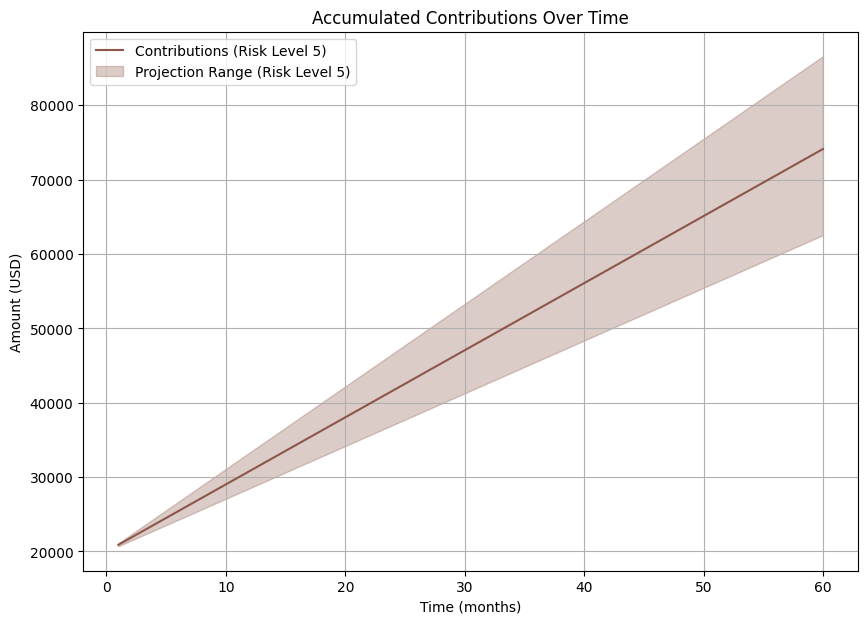

In [5]:
import matplotlib.pyplot as plt

# Plotting
def plot_accumulated_contribution(suggestions, months, current_lumpsum):
    plt.figure(figsize=(10, 7))
    
    for risk_level, data in suggestions.items():
        projection_min = data['range'][0]
        projection_max = data['range'][1]
        monthly_contribution = data["mid_point"]
        
        time = np.arange(1, months + 1)
        contributions = current_lumpsum + np.cumsum([monthly_contribution] * months)
        contribution_min = current_lumpsum + np.cumsum([projection_min] * months)
        contribution_max = current_lumpsum + np.cumsum([projection_max] * months)
        
        plt.plot(time, contributions, label=f'Contributions (Risk Level {risk_level})', color=f'C{risk_level}')
        plt.fill_between(time, contribution_min, contribution_max, alpha=0.3, color=f'C{risk_level}', label=f'Projection Range (Risk Level {risk_level})')
 
    plt.xlabel('Time (months)')
    plt.ylabel('Amount (USD)')
    plt.title('Accumulated Contributions Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()
 
# Call the plotting function
plot_accumulated_contribution({risk_level: suggestion}, months, current_lumpsum)